In [1]:
import operator
import math
import random

import numpy as np
import matplotlib.pyplot as plt

import sys
import gc

import optuna
import logging

from collections.abc import Callable

from pso_utils import *
from landscapes_utils import *

from functools import partial

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
from deap import gp

In [176]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x5
NUM_PROBLEMS = 100
gp_run_check = True # when true we can perform the run

In [177]:
def save_log(log, path='logs/log_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(log, lb_file)

def load_log(path='logs/log_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

def save_hof(hof, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(hof, lb_file)

def load_hof(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)
    
def save_pop(pop, path='logs/hof_uniform.pkl'):
    with open(path, 'wb') as lb_file:
        pickle.dump(pop, lb_file)

def load_pop(path='logs/hof_uniform.pkl'):
    with open(path, 'rb') as lb_file:
        return pickle.load(lb_file)

In [178]:
def get_ones(_):
    return np.ones((SWARM_SIZE, 2))

def get_pi(_):
    return get_ones(None) * np.pi

In [179]:
def func_dec(func):
    def new_func(swarm, velocity, global_best, personal_best, center_mass, dispersion):
        value = func(swarm, velocity, global_best, personal_best, center_mass, dispersion)
        if not isinstance(value, np.ndarray):
            return np.zeros((SWARM_SIZE, 2))
        else:
            try:
                value.shape[1] == 2
                return value
            except Exception:
                value = value.reshape(-1, 1)
                value = np.hstack((value, value))
                return value
    return new_func

In [180]:
def gen_rand(_):
    return np.random.uniform(np.zeros(2), np.ones(2), size=(SWARM_SIZE, 2))

In [193]:
def GP_RUN(name=None):
    pset = gp.PrimitiveSet("MAIN", 6)
    # basic
    pset.addPrimitive(np.add, 2)
    pset.addPrimitive(np.negative, 1)
    pset.addPrimitive(np.subtract, 2)
    pset.addPrimitive(np.multiply, 2)
    pset.addPrimitive(gen_rand, 1)

    # # random
    # pset.addPrimitive(gen_random, 1)

    # others
    # pset.addPrimitive(np.cos, 1)
    # pset.addPrimitive(np.sin, 1)


    # PRIMITIVES
    pset.addTerminal(np.pi)
    pset.addTerminal(1)
    # ephemeral constants
    pset.addEphemeralConstant("rand101", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand102", partial(random.uniform, 0, 5))
    pset.addEphemeralConstant("rand103", partial(random.uniform, 0, 5))


    # variables
    pset.renameArguments(ARG0="swarm")
    pset.renameArguments(ARG1="vel")
    pset.renameArguments(ARG2='gbest')
    pset.renameArguments(ARG3='pbest')
    pset.renameArguments(ARG4='center')
    pset.renameArguments(ARG5='dispersion')
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("expr", gp.genHalfAndHalf, pset=pset, min_=6, max_=10) # 3<5
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("compile", gp.compile, pset=pset)

    def GPFitness(individual):
        problems = generate_problems(NUM_PROBLEMS)
        func = toolbox.compile(expr=individual)
        func = func_dec(func)
        vel_update = func
        S = SwarmGP(SWARM_SIZE, vel_update=vel_update)
        results = PSOResults(S, problems, NUM_ITERATIONS)
        value = float(np.median(results) + np.std(results))
        print(f'value = {value} -> ind = {individual}')
        return value,

    # def multi_mutate(individual):
    #     """Apply a random mutation type to the individual."""

    #     choose = random.randint(0, 2)
    #     if choos == 0:
    #         mutant, = 

        # mutation_functions = [toolbox.mutUniform, toolbox.mutShrink]
        # mutation = random.choice(mutation_functions)
        # mutant, = mutation(individual)  # Apply the chosen mutation
        # return mutant,


    toolbox.register("evaluate", GPFitness)
    toolbox.register("select", tools.selTournament, tournsize=3) # 1:1 replacement selection
    toolbox.register("mate", gp.cxOnePoint) # subtree crossover
    # mutations
    # toolbox.register("expr_mut", gp.genFull, min_=0, max_=6)
    # toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)
    toolbox.register("mutate", gp.mutShrink)
    toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))
    toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=12))

    def gp_run():
        random.seed(318)

        pop = toolbox.population(n=50)
        hof = tools.HallOfFame(5)

        stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
        stats_size = tools.Statistics(len)
        stats_height = tools.Statistics(lambda ind: ind.height)
        mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size, height=stats_height)
        mstats.register("avg", np.mean)
        mstats.register("std", np.std)
        mstats.register("min", np.min)
        mstats.register("max", np.max)

        pop, log = algorithms.eaSimple(pop, toolbox, 0.5, 0.2, ngen=20, stats=mstats,
                                    halloffame=hof, verbose=False)
        # doesn't recompute individuals that do not change
        if name is not None:
            save_hof(hof, f'logs/hof_{name}')
            save_pop(pop, f'logs/pop_{name}')
            save_log(log, f'logs/log_{name}')
            
        return pop, log, hof
    return gp_run()

In [194]:
if gp_run_check:
    pop, log, hof = GP_RUN(name='shrink_0.1')

# 0.5, 0.1, 50*20, uniform -> 25

c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
c:\Users\andre\AppData\Local\Programs\Python\Python312\Lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


value = 97.21216347464613 -> ind = multiply(multiply(negative(gen_rand(subtract(multiply(1.879534846460591, negative(negative(vel))), multiply(1, 1)))), multiply(add(multiply(gen_rand(pbest), negative(pbest)), subtract(negative(0.18631821674250593), add(dispersion, add(vel, 1.820679803899627)))), multiply(add(gen_rand(swarm), gen_rand(center)), add(subtract(3.7842350973603693, 3.141592653589793), multiply(swarm, vel))))), add(multiply(multiply(subtract(gen_rand(1), negative(center)), gen_rand(subtract(negative(4.5546037709544285), multiply(3.1733298303216957, swarm)))), subtract(subtract(add(add(1, negative(negative(3.141592653589793))), gbest), multiply(add(swarm, subtract(3.141592653589793, pbest)), center)), gen_rand(add(pbest, swarm)))), multiply(negative(add(gen_rand(3.141592653589793), subtract(dispersion, add(3.141592653589793, 1.2154254509882612)))), negative(negative(negative(pbest))))))
value = 23.534554447904135 -> ind = gen_rand(multiply(multiply(gen_rand(multiply(gen_rand(

# Results

In [196]:
for i in range(len(hof)):
    print(f'height = {hof[0].height} and len = {len(hof[0])} -> {hof[0]}')

height = 12 and len = 109 -> multiply(multiply(negative(subtract(negative(subtract(multiply(negative(multiply(1, center)), add(0.6379050917585183, swarm)), negative(subtract(subtract(2.5976826249575713, swarm), add(2.2424847093403404, 1))))), gen_rand(negative(add(subtract(add(0.7511685765836129, 4.231139922061712), add(3.141592653589793, gen_rand(multiply(negative(swarm), negative(2.877495403294305))))), negative(subtract(negative(pbest), add(1, 3.141592653589793)))))))), gen_rand(negative(multiply(negative(negative(add(negative(gbest), negative(1)))), gen_rand(gen_rand(gen_rand(negative(center)))))))), gen_rand(gen_rand(subtract(add(multiply(negative(subtract(gen_rand(add(2.00708637107485, 3.141592653589793)), gen_rand(multiply(negative(swarm), 4.406842878716747)))), multiply(multiply(multiply(add(0.7511685765836129, 4.231139922061712), add(dispersion, gen_rand(0.5272135333986244))), multiply(negative(swarm), negative(2.877495403294305))), subtract(multiply(negative(pbest), negative(

In [ ]:
# first shrink attempt with len = 3 and len = 6 -> negative(multiply(swarm, subtract(3.141592653589793, 1)))

In [197]:
print(log)

   	      	                    fitness                     	                     height                     	                      size                     
   	      	------------------------------------------------	------------------------------------------------	-----------------------------------------------
gen	nevals	avg    	gen	max    	min    	nevals	std     	avg  	gen	max	min	nevals	std     	avg   	gen	max	min	nevals	std    
0  	50    	78.1737	0  	157.771	3.85313	50    	51.9631 	8.4  	0  	10 	6  	50    	1.41421 	143.66	0  	544	21 	50    	133.243
1  	29    	33.6103	1  	141.981	3.09884	29    	28.8675 	8.52 	1  	12 	6  	29    	1.66421 	113.72	1  	501	11 	29    	116.678
2  	34    	16.0545	2  	30.1009	3.09884	34    	8.32496 	9.06 	2  	12 	2  	34    	2.02396 	89.28 	2  	370	5  	34    	71.9733
3  	29    	9.51352	3  	23.4564	3.09884	29    	7.50114 	9.34 	3  	12 	1  	29    	2.25042 	102.84	3  	360	2  	29    	66.8549
4  	33    	5.81543	4  	39.8755	3.09884	33    	6.70536 	10.18	4  	12 	7 

# plot

In [198]:
log_uni = load_log()

In [199]:
def plot(log):
    gen = log.select("gen")
    fit_mins = log.chapters["fitness"].select("min")
    size_avgs = log.chapters["height"].select("avg")

    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots()
    line1 = ax1.plot(gen, fit_mins, "b-", label="Minimum Fitness")
    ax1.set_xlabel("Generation")
    ax1.set_ylabel("Fitness", color="b")
    ax1.axhline(y = 2.21, color = 'b', linestyle = ':')
    for tl in ax1.get_yticklabels():
        tl.set_color("b")

    ax2 = ax1.twinx()
    line2 = ax2.plot(gen, size_avgs, "r-", label="Average Height")
    ax2.set_ylabel("Height", color="r")
    for tl in ax2.get_yticklabels():
        tl.set_color("r")

    lns = line1 + line2
    labs = [l.get_label() for l in lns]
    ax1.legend(lns, labs, loc="center right")

    return plt

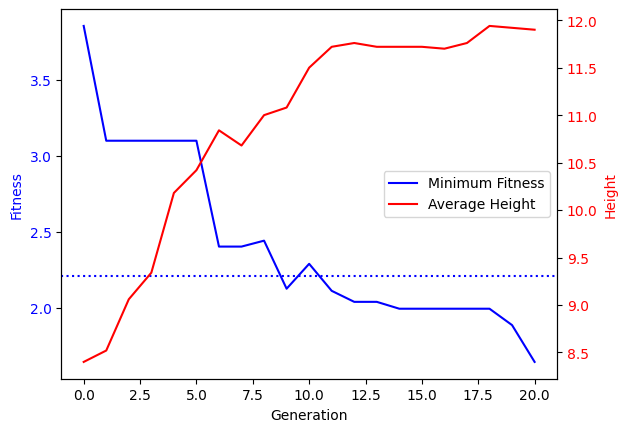

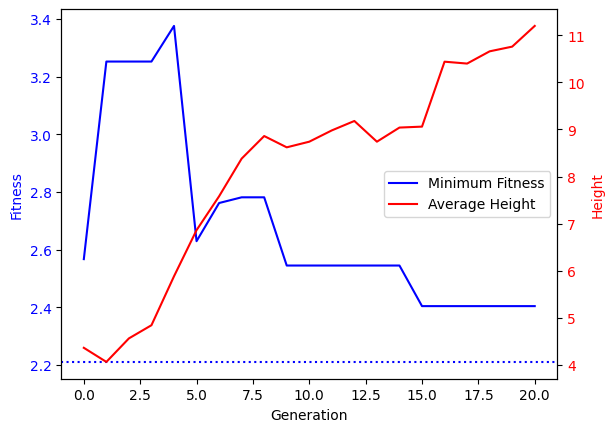

In [200]:
plt = plot(log)
plt2 = plot(log_uni)
plt.show()